# Natural Computing
## Assignment 3
### Exercise 1

#### Imports

In [1]:
import pandas as pd
import numpy as np
import subprocess
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pickle

#### Preparing some functions for running the Java code and retrieve results

**!For this notebook to run successfully, Java for running the negsel2.jar file is required!**

In [11]:
def get_results_with(is_ex1, data_dir, fn_alpha, fn_train, fn_test, n, r):
    """Runs negsel2.jar via command line and returns the results
    """
    # build the command string
    cmd = "java -jar negsel2.jar "
    if not is_ex1:
        if fn_alpha:
            cmd += f" -alphabet file://{data_dir+fn_alpha} "
        else:
            raise ValueError("Alphabet file must be given")
    cmd += f" -self {data_dir+fn_train} -n {n} -r {r} -c -l < {data_dir+fn_test}"

    # run the command and store the results
    stream = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True, shell=True)
#     print(stream.stdout)
    out = stream.stdout.split()
    return np.asarray(out, dtype=float)

def plot_roc_and_auc(training, test, train_label, test_label, rs, plot_rs=None):
    """Computes AUC-values and plots AUC and ROC curves.
    
    training and test1 may be the same data, e.g. both are scores obtained from 'english.test'.
    train_label: label for the plots
    test_label: label for the plots
    rs: the list of r-values used
    plot_rs: if None function will plot all r in the ROC curve, can be limited by passing a list. E.g.: [4,9].
    """
    aucs = []
    if plot_rs is None:
        plot_rs = rs
    
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    fig.suptitle(f"AUC- and ROC-curves of {train_label} vs. {test_label}")
    axs[0].plot([0,1], [0,1], 'k--', label="chance")
    for i, r in enumerate(rs):
        train_flat = np.asarray(training[i]).flatten()
        test_flat = np.asarray(test[i]).flatten()
        scores = np.concatenate((train_flat, test_flat))
        true_labels = np.zeros_like(scores, dtype=int)
        idx_true = np.asarray(training[i]).flatten().shape[0]
        true_labels[idx_true:] = 1

        aucs += [roc_auc_score(true_labels, scores)]
        # make ROC curves
        if r in plot_rs:
            fpr, tpr, thresholds = roc_curve(true_labels, scores)
            axs[0].plot(fpr, tpr, label=f"r={r}")
    title = f"ROC curve of {train_label} vs. {test_label}"
    axs[0].set_title(title)
    axs[0].set_xlabel("Specificity / FPR")
    axs[0].set_ylabel("Sensitivity / TPR")
    axs[0].legend()
    
    axs[1].plot(rs, aucs)
    axs[1].set_title(f"AUC curve of {train_label} vs. {test_label}")
    axs[1].set_xlabel("r-values")
    axs[1].set_ylabel("AUC-values")
#     plt.savefig(f"{train_label} vs {test_label}-r{str(plot_rs)}.png")
    plt.show()
    
def run_ex1(load_dict=True, save_dict=True):
    """
    is_ex1: Bool. Switches between exercise 1 and 2.
    load_dict: Bool. Instead of computing the anomaly scores again, loads a stored dictionary file.
    save_dict: Bool. If load_dict is False, save the newly computed anomaly scores if save_dict is True, don't save them if False.
    """
    dict_filename = 'results/ex1_anomaly_scores_dict.pkl'

    rs = list(range(1, 11))
    # either load the scores or make a new run and overwrite the old file
    if load_dict:
        # loading the anomaly score from a file
        try:
            anomaly_scores = None
            with open(dict_filename, 'rb') as dict_file:
                anomaly_scores = pickle.load(dict_file)
            return anomaly_scores, rs
        except:
            raise FileNotFoundError(f"{dict_filename} not found.")
    else:
        n = 10
        data_dir = "lang/"
        filenames_test = ["english.test", "tagalog.test", 
                          "hiligaynon.txt", "middle-english.txt",
                          "plautdietsch.txt", "xhosa.txt"]
        filename_alpha = None  # ex1 does not have an alphabet file
        filename_train = "english.train"

        keys = [key.split(".")[0].split("/")[-1] for key in filenames_test]  # split removes the .txt and 'lang/', so the keys are shorter
        anomaly_scores = {f"{k}":[] for k in keys}

        # for each test file in test_fnames
        for i, fn_test in enumerate(filenames_test):

            # for each r-value in rs compute the anomaly scores
            print(f"run analysis on {keys[i]}")
            for r in rs:
                out = get_results_with(True, data_dir, filename_alpha, filename_train, fn_test, n, r)
                anomaly_scores[keys[i]] += [out]
        print("done.")

        # # save the anomaly scores to a file
        if save_dict:
            with open(dict_filename, 'wb') as dict_file:
                pickle.dump(anomaly_scores, dict_file)
        return anomaly_scores, rs

run analysis on english
run analysis on tagalog
run analysis on hiligaynon
run analysis on middle-english
run analysis on plautdietsch
run analysis on xhosa
done.


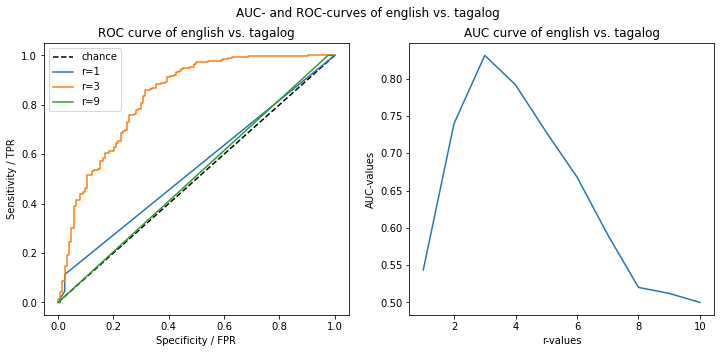

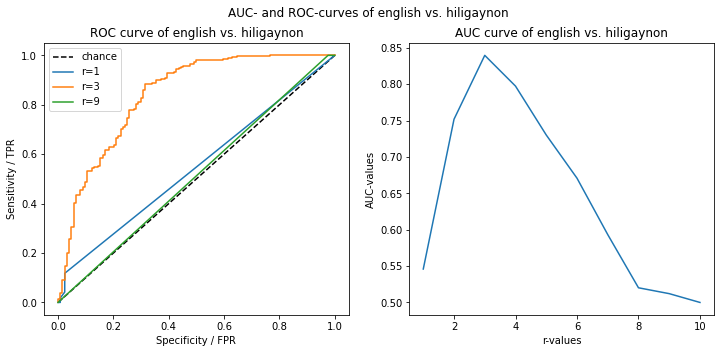

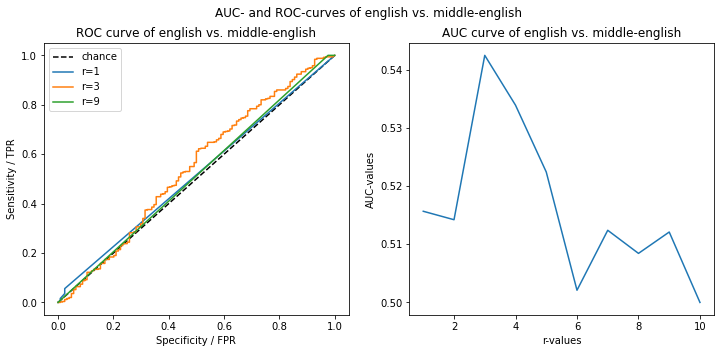

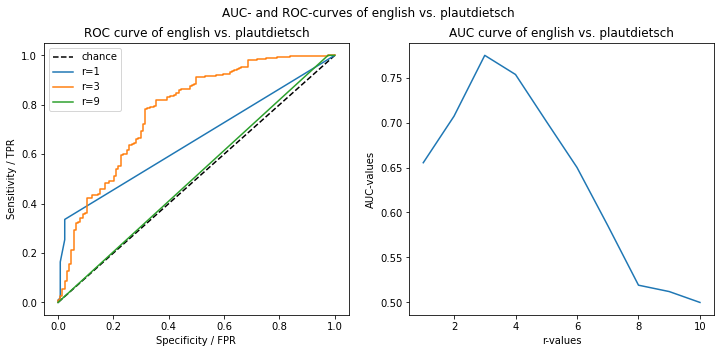

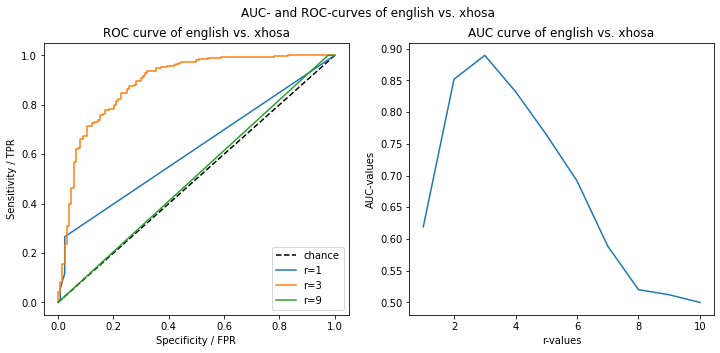

In [12]:
# plotting
anomaly_scores, rs = run_ex1(load_dict=True)
plot_rs = [1,3,9]  # plots all r in the ROC curve, can be limited by passing a list. E.g.: [4,9]
eng = anomaly_scores["english"]
for key in anomaly_scores.keys():
    if key != "english":
        plot_roc_and_auc(eng, anomaly_scores[key], "english", key, rs, plot_rs)

### Exercise 2

#### Imports and functions

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess
import pickle
import math
import os

In [14]:
def chunk_data(in_path, out_path, chunk_length=7, overwrite=False):
    """The program automatically creates the new file to store the formatted data
    """
    if not os.path.exists(out_path) or overwrite:
        chunk_length = 7
        with open(in_path, 'r') as train_file, open(out_path, 'w') as clean_file:
            overspill_counter = 0
            lines = train_file.readlines()
            num_lines = len(lines)
            for line in lines:
                line = line.rstrip("\n")  # remove the last \n which otherwise will count towards the chunk-length and cause NaNs!
                
                overspill = max(0,len(line)%chunk_length)
                exclude_halves = len(line) - overspill
                for i in range(0, exclude_halves, chunk_length):
                    clean_file.write(line[i:i+chunk_length])
                    if i < len(line) - overspill - chunk_length:
                        clean_file.write('\n')
                if overspill != 0:
                    clean_file.write('\n')
#                     assert len(line[-1-chunk_length:-1]) == chunk_length
#                     clean_file.write(line[-1-chunk_length:-1])  # takes the last chunk_length values of line instead of dropping it
                    overspill_counter += 1
        print(f"File created: '{out_path}' ")
        print(f"Overspill occured {overspill_counter}/{num_lines} times.")
    else:
        print(f"The file '{out_path}' already exists. No overwrite.")

In [34]:
def run_ex2(dataset_name, test_sets, rs, overwrite=False):
    """Runs ex2 for the given dataset.
    
    dataset: 'cert' or 'unm'
    """
    chunk_length = 7
    print(f"Working on the {dataset_name} dataset")
    
    # Chunk the training data
    train_cert_filepath = f"syscalls/snd-{dataset_name}/snd-{dataset_name}.train"
    train_cert_filepath_clean = f"syscalls/snd-{dataset_name}-clean/{dataset_name}.train"
    chunk_data(train_cert_filepath, train_cert_filepath_clean, 7, overwrite)
    
    # Define the filepaths
    fpath_train = f"syscalls/snd-{dataset_name}-clean/{dataset_name}.train"
    fpath_alphabet = f"syscalls/snd-{dataset_name}/snd-{dataset_name}.alpha"
    data_dir = f"syscalls/snd-{dataset_name}/"
    fpaths_test_labels = test_sets

    # Define filepath of the temporary output file
    fpath_temp = f"syscalls/snd-{dataset_name}-clean/{dataset_name}-temp.test"
    
    # For each r-value in r we store the true_labels and anomaly scores
    n_testsets = len(fpaths_test_labels)
    true_labels = [[[] for _ in range(n_testsets)] for _ in range(chunk_length)]
    anom_scores = [[[] for _ in range(n_testsets)] for _ in range(chunk_length)]
    for i, r in enumerate(rs):
        print(f"\tCurrent r-value: {r}")
        
        # For each test-set we run the analysis
        for j, path in enumerate(fpaths_test_labels):
            # read the test and labels files
            print(f"\t\tRunning on '{path}'...")
            test_set_labels = []
            test_set_scores = []
            with open(data_dir+path[0], 'r') as test_file, open(data_dir+path[1], 'r') as labels_file:
                for line in test_file:
                    line = line.rstrip("\n")
                    overspill = max(0,len(line)%chunk_length)
                    exclude_halves = len(line) - overspill

                    #### split in chunks and write chunks to temporary file
                    with open(fpath_temp, 'w') as temp_file:
                        for k in range(0, exclude_halves, chunk_length):
                            temp_file.write(line[k:k+chunk_length])
                            if k < len(line) - overspill - chunk_length:
                                temp_file.write("\n")
                        if overspill != 0:
                            temp_file.write("\n")
#                             assert len(line[-1-chunk_length:-1]) == chunk_length
#                             temp_file.write(line[-1-chunk_length:-1])  # takes the last chunk_length values of line instead of dropping it

                    #### run the Java algorithm
                    cmd = f"java -jar negsel2.jar -alphabet file://{fpath_alphabet} "
                    cmd += f" -self {fpath_train} -n {chunk_length} -r {r} -c -l < {fpath_temp}"
                    # run the command and store the results
                    stream = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True, shell=True)
                    out = np.asarray(stream.stdout.split(), dtype=float)
                    assert np.any(np.isnan(out)) == False
                    
                    #### compute and store average anomaly score as well as the true labels
                    label = labels_file.readline()
                    test_set_labels.append(int(label))
                    test_set_scores.append(np.average(out))
            true_labels[i][j] = test_set_labels
            anom_scores[i][j] = test_set_scores
    print('done.')
    return true_labels, anom_scores

In [35]:
def plot_ex2(true_labels, anom_scores, dataset_name, fig_savename, rs, plot_rs=None):
    plot_rs = rs if plot_rs is None else plot_rs
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    fig.suptitle(f"AUC- and ROC-curves of {dataset_name}")
    axs[0].plot([0,1], [0,1], 'k--', label="chance")
    
    total_aucs = []  # for the AUC-scores of the merged test-sets
    for i, r in enumerate(rs):        
        # get merged AUC score
        flat_labels = [item for sublist in true_labels[i] for item in sublist]
        flat_scores = [item for sublist in anom_scores[i] for item in sublist]
        auc_score = roc_auc_score(flat_labels, flat_scores)
        total_aucs.append(auc_score)
        
        # make ROC curves
        if r in plot_rs:
            fpr, tpr, thresholds = roc_curve(flat_labels, flat_scores)
            axs[0].plot(fpr, tpr, label=f"r={r}")
    title = f"ROC curve of {dataset_name}"
    axs[0].set_title(title)
    axs[0].set_xlabel("Specificity / FPR")
    axs[0].set_ylabel("Sensitivity / TPR")
    axs[0].legend()
    
    print(rs)
    print(total_aucs)
    axs[1].plot(rs, total_aucs, label="AUC merged")
    axs[1].set_title(f"AUC curve of {dataset_name}")
    axs[1].set_xlabel("r-values")
    axs[1].set_ylabel("AUC-values")
    axs[1].legend()
    plt.savefig(f"results/{fig_savename}.png")
    plt.show()

In [36]:
def plot_and_run_ex2_with(dataset_name, test_sets, rs, plot_rs, results_fname, overwrite=False):
    results_path = f"results/{results_fname}.pkl"
    
    true_labels, anom_scores = None, None
    if not os.path.exists(results_path) or overwrite:
        # compute the results
        true_labels, anom_scores = run_ex2(dataset_name, test_sets, rs, overwrite)
        # save the results
        with open(results_path, 'wb') as result_file:
            pickle.dump((true_labels, anom_scores), result_file)
    else:
        # load the results
        with open(results_path, 'rb') as result_file:
            true_labels, anom_scores = pickle.load(result_file)
        print(f"Loaded '{results_path}'.")
    plot_ex2(true_labels, anom_scores, dataset_name, results_fname, rs)
    return true_labels, anom_scores

Working on the cert dataset
The file 'syscalls/snd-cert-clean/cert.train' already exists. No overwrite.
	Current r-value: 1
		Running on '['snd-cert.1.test', 'snd-cert.1.labels']'...
		Running on '['snd-cert.2.test', 'snd-cert.2.labels']'...
		Running on '['snd-cert.3.test', 'snd-cert.3.labels']'...
	Current r-value: 2
		Running on '['snd-cert.1.test', 'snd-cert.1.labels']'...
		Running on '['snd-cert.2.test', 'snd-cert.2.labels']'...
		Running on '['snd-cert.3.test', 'snd-cert.3.labels']'...
	Current r-value: 3
		Running on '['snd-cert.1.test', 'snd-cert.1.labels']'...
		Running on '['snd-cert.2.test', 'snd-cert.2.labels']'...
		Running on '['snd-cert.3.test', 'snd-cert.3.labels']'...
	Current r-value: 4
		Running on '['snd-cert.1.test', 'snd-cert.1.labels']'...
		Running on '['snd-cert.2.test', 'snd-cert.2.labels']'...
		Running on '['snd-cert.3.test', 'snd-cert.3.labels']'...
	Current r-value: 5
		Running on '['snd-cert.1.test', 'snd-cert.1.labels']'...
		Running on '['snd-cert.2.te

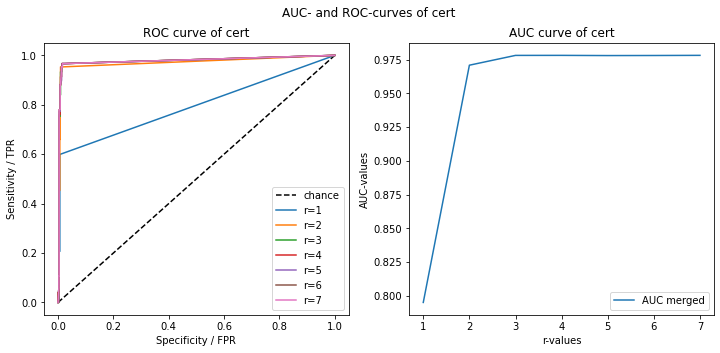

In [37]:
rs = list(range(1,7+1))
plot_rs = None
dataset_name = 'cert'
results_fname = f"ex2_{dataset_name}_merged_labels_and_scores"
test_sets = [[f"snd-{dataset_name}.1.test", f"snd-{dataset_name}.1.labels"],
             [f"snd-{dataset_name}.2.test", f"snd-{dataset_name}.2.labels"],
             [f"snd-{dataset_name}.3.test", f"snd-{dataset_name}.3.labels"]]
true_labels, anom_scores = plot_and_run_ex2_with(dataset_name, test_sets, rs, plot_rs, results_fname, overwrite=False)

Working on the unm dataset
The file 'syscalls/snd-unm-clean/unm.train' already exists. No overwrite.
	Current r-value: 1
		Running on '['snd-unm.1.test', 'snd-unm.1.labels']'...
		Running on '['snd-unm.2.test', 'snd-unm.2.labels']'...
		Running on '['snd-unm.3.test', 'snd-unm.3.labels']'...
	Current r-value: 2
		Running on '['snd-unm.1.test', 'snd-unm.1.labels']'...
		Running on '['snd-unm.2.test', 'snd-unm.2.labels']'...
		Running on '['snd-unm.3.test', 'snd-unm.3.labels']'...
	Current r-value: 3
		Running on '['snd-unm.1.test', 'snd-unm.1.labels']'...
		Running on '['snd-unm.2.test', 'snd-unm.2.labels']'...
		Running on '['snd-unm.3.test', 'snd-unm.3.labels']'...
	Current r-value: 4
		Running on '['snd-unm.1.test', 'snd-unm.1.labels']'...
		Running on '['snd-unm.2.test', 'snd-unm.2.labels']'...
		Running on '['snd-unm.3.test', 'snd-unm.3.labels']'...
	Current r-value: 5
		Running on '['snd-unm.1.test', 'snd-unm.1.labels']'...
		Running on '['snd-unm.2.test', 'snd-unm.2.labels']'...
	

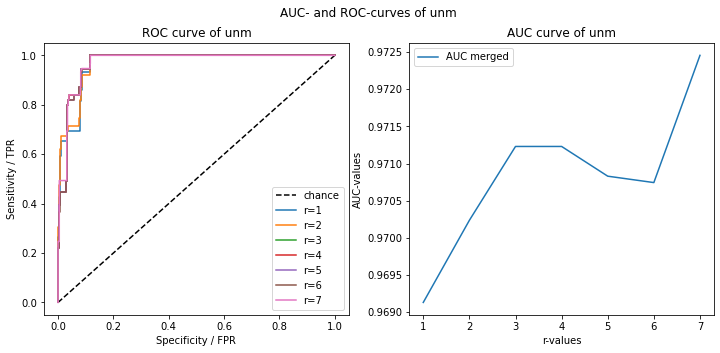

In [38]:
rs = list(range(1,7+1))
plot_rs = None
dataset_name = 'unm'
results_fname = f"ex2_{dataset_name}_merged_labels_and_scores"
test_sets = [[f"snd-{dataset_name}.1.test", f"snd-{dataset_name}.1.labels"],
             [f"snd-{dataset_name}.2.test", f"snd-{dataset_name}.2.labels"],
             [f"snd-{dataset_name}.3.test", f"snd-{dataset_name}.3.labels"]]
true_labels, anom_scores = plot_and_run_ex2_with(dataset_name, test_sets, rs, plot_rs, results_fname, overwrite=False)

##### Running the test sets individually

Working on the cert dataset
The file 'syscalls/snd-cert-clean/cert.train' already exists. No overwrite.
	Current r-value: 1
		Running on '['snd-cert.1.test', 'snd-cert.1.labels']'...
	Current r-value: 2
		Running on '['snd-cert.1.test', 'snd-cert.1.labels']'...
	Current r-value: 3
		Running on '['snd-cert.1.test', 'snd-cert.1.labels']'...
	Current r-value: 4
		Running on '['snd-cert.1.test', 'snd-cert.1.labels']'...
	Current r-value: 5
		Running on '['snd-cert.1.test', 'snd-cert.1.labels']'...
	Current r-value: 6
		Running on '['snd-cert.1.test', 'snd-cert.1.labels']'...
	Current r-value: 7
		Running on '['snd-cert.1.test', 'snd-cert.1.labels']'...
done.
[1, 2, 3, 4, 5, 6, 7]
[0.8200000000000001, 0.9795999999999999, 0.9783999999999999, 0.9779999999999999, 0.9773999999999999, 0.9779999999999999, 0.9779999999999999]


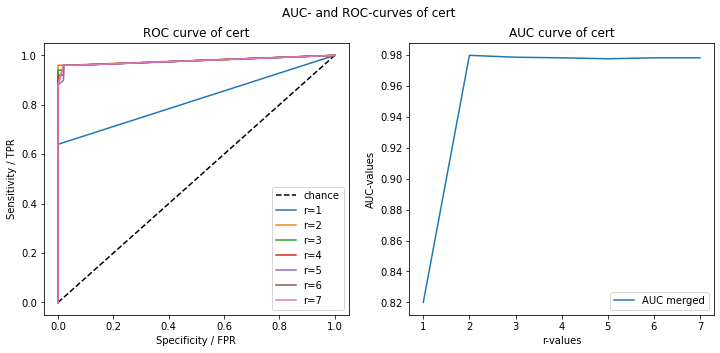

Working on the cert dataset
The file 'syscalls/snd-cert-clean/cert.train' already exists. No overwrite.
	Current r-value: 1
		Running on '['snd-cert.2.test', 'snd-cert.2.labels']'...
	Current r-value: 2
		Running on '['snd-cert.2.test', 'snd-cert.2.labels']'...
	Current r-value: 3
		Running on '['snd-cert.2.test', 'snd-cert.2.labels']'...
	Current r-value: 4
		Running on '['snd-cert.2.test', 'snd-cert.2.labels']'...
	Current r-value: 5
		Running on '['snd-cert.2.test', 'snd-cert.2.labels']'...
	Current r-value: 6
		Running on '['snd-cert.2.test', 'snd-cert.2.labels']'...
	Current r-value: 7
		Running on '['snd-cert.2.test', 'snd-cert.2.labels']'...
done.
[1, 2, 3, 4, 5, 6, 7]
[0.78396, 0.96288, 0.98394, 0.98418, 0.9841399999999999, 0.9843199999999999, 0.9843599999999999]


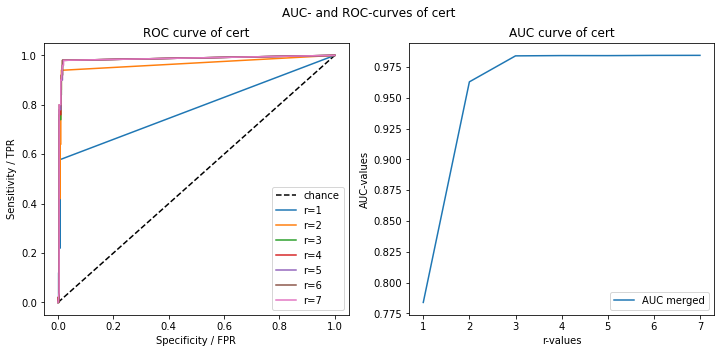

Working on the cert dataset
The file 'syscalls/snd-cert-clean/cert.train' already exists. No overwrite.
	Current r-value: 1
		Running on '['snd-cert.3.test', 'snd-cert.3.labels']'...
	Current r-value: 2
		Running on '['snd-cert.3.test', 'snd-cert.3.labels']'...
	Current r-value: 3
		Running on '['snd-cert.3.test', 'snd-cert.3.labels']'...
	Current r-value: 4
		Running on '['snd-cert.3.test', 'snd-cert.3.labels']'...
	Current r-value: 5
		Running on '['snd-cert.3.test', 'snd-cert.3.labels']'...
	Current r-value: 6
		Running on '['snd-cert.3.test', 'snd-cert.3.labels']'...
	Current r-value: 7
		Running on '['snd-cert.3.test', 'snd-cert.3.labels']'...
done.
[1, 2, 3, 4, 5, 6, 7]
[0.78546, 0.9746799999999999, 0.97514, 0.97506, 0.9748399999999999, 0.9748399999999998, 0.9749499999999999]


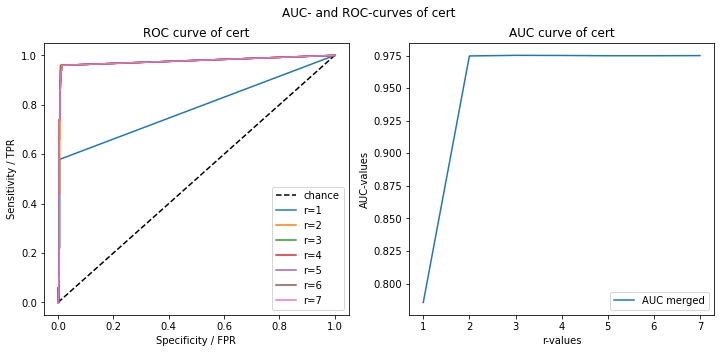

Working on the unm dataset
The file 'syscalls/snd-unm-clean/unm.train' already exists. No overwrite.
	Current r-value: 1
		Running on '['snd-unm.1.test', 'snd-unm.1.labels']'...
	Current r-value: 2
		Running on '['snd-unm.1.test', 'snd-unm.1.labels']'...
	Current r-value: 3
		Running on '['snd-unm.1.test', 'snd-unm.1.labels']'...
	Current r-value: 4
		Running on '['snd-unm.1.test', 'snd-unm.1.labels']'...
	Current r-value: 5
		Running on '['snd-unm.1.test', 'snd-unm.1.labels']'...
	Current r-value: 6
		Running on '['snd-unm.1.test', 'snd-unm.1.labels']'...
	Current r-value: 7
		Running on '['snd-unm.1.test', 'snd-unm.1.labels']'...
done.
[1, 2, 3, 4, 5, 6, 7]
[0.956, 0.9583999999999999, 0.9396, 0.9396, 0.9388, 0.9384, 0.9408]


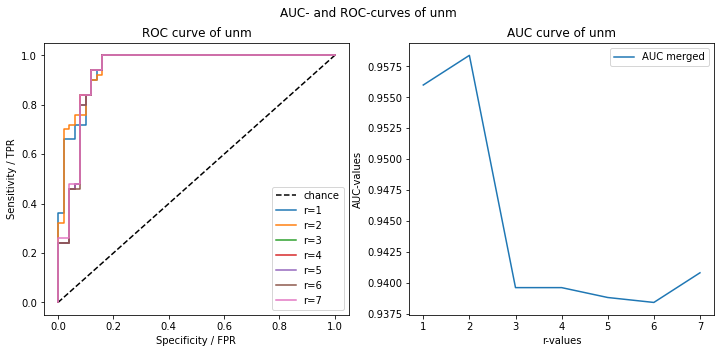

Working on the unm dataset
The file 'syscalls/snd-unm-clean/unm.train' already exists. No overwrite.
	Current r-value: 1
		Running on '['snd-unm.2.test', 'snd-unm.2.labels']'...
	Current r-value: 2
		Running on '['snd-unm.2.test', 'snd-unm.2.labels']'...
	Current r-value: 3
		Running on '['snd-unm.2.test', 'snd-unm.2.labels']'...
	Current r-value: 4
		Running on '['snd-unm.2.test', 'snd-unm.2.labels']'...
	Current r-value: 5
		Running on '['snd-unm.2.test', 'snd-unm.2.labels']'...
	Current r-value: 6
		Running on '['snd-unm.2.test', 'snd-unm.2.labels']'...
	Current r-value: 7
		Running on '['snd-unm.2.test', 'snd-unm.2.labels']'...
done.
[1, 2, 3, 4, 5, 6, 7]
[0.9706400000000001, 0.97156, 0.9718399999999999, 0.9718399999999999, 0.9713999999999999, 0.9711599999999999, 0.97276]


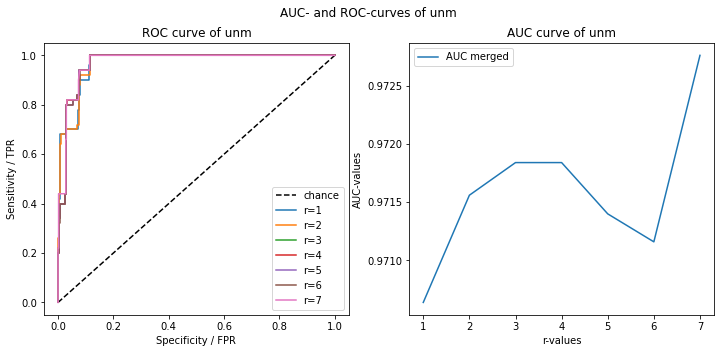

Working on the unm dataset
The file 'syscalls/snd-unm-clean/unm.train' already exists. No overwrite.
	Current r-value: 1
		Running on '['snd-unm.3.test', 'snd-unm.3.labels']'...
	Current r-value: 2
		Running on '['snd-unm.3.test', 'snd-unm.3.labels']'...
	Current r-value: 3
		Running on '['snd-unm.3.test', 'snd-unm.3.labels']'...
	Current r-value: 4
		Running on '['snd-unm.3.test', 'snd-unm.3.labels']'...
	Current r-value: 5
		Running on '['snd-unm.3.test', 'snd-unm.3.labels']'...
	Current r-value: 6
		Running on '['snd-unm.3.test', 'snd-unm.3.labels']'...
	Current r-value: 7
		Running on '['snd-unm.3.test', 'snd-unm.3.labels']'...
done.
[1, 2, 3, 4, 5, 6, 7]
[0.96712, 0.9676800000000001, 0.97392, 0.97392, 0.9739199999999999, 0.97384, 0.97604]


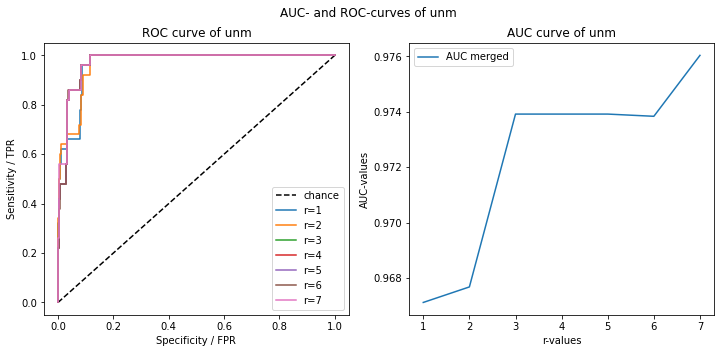

In [42]:
rs = list(range(1,7+1))
plot_rs = None
dataset_names = ['cert', 'unm']
for dataset_name in dataset_names:
    test_sets = [[f"snd-{dataset_name}.1.test", f"snd-{dataset_name}.1.labels"],
                 [f"snd-{dataset_name}.2.test", f"snd-{dataset_name}.2.labels"],
                 [f"snd-{dataset_name}.3.test", f"snd-{dataset_name}.3.labels"]]
    for i, test_set in enumerate(test_sets):
        results_fname = f"ex2_{dataset_name}_{i+1}_labels_and_scores"
        true_labels, anom_scores = plot_and_run_ex2_with(dataset_name, [test_set], rs, plot_rs, results_fname, overwrite=False)
        